# Data Analysis Template Notebook

Welcome to the Data Analysis Template Notebook! This notebook constitutes an example of how the data should be preprocessed and analysed. It follows the pipelines reported in the [Jupyter Book](https://vivineuro.github.io/Neuromatch-Data-Analysis-Team-Organization/WorkTogether/Imports%20%26%20Loading%20set%20up.html). Please do not hesitate to reach out to `#a-24-evaluation` if you have any questions or something in unclear.


<a id='Imports'></a>
## Imports set up

At the top of every notebook, we define an **Imports** section where all necessary packages and libraries should be imported. This ensures that all dependencies are loaded at the beginning of the notebook, making it easy to track what packages are in use.

In [1]:
!pip install tabulate
from tabulate import tabulate

# General imports
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import glob          # For file searching
import re            # For pattern matching
import itertools

# Visualization imports
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns            # Statistical data visualization

# Display high-quality plots in SVG format
from IPython import display
display.set_matplotlib_formats('svg')  # Recommended for better plot quality

# to restrict the float value to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# display max numer of columns. Change the value as needed.
pd.set_option('display.max_columns', 100)

<ipython-input-1-5f4beceb50cd>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')  # Recommended for better plot quality


<a id='Data-Loading'></a>
## Data Loading

In this section, we’ll use Google Drive to store and load datasets. The code below mounts Google Drive, finds all CSV files with a specified prefix in a given folder, and loads each CSV file into a dictionary of DataFrames for easy access.

In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

folder_path = "/content/drive/MyDrive/Academies_DataAnalysis/July2024/DailySurveys/CN/TAs/"
file_prefix = "CN"  # Replace with your desired prefix

csv_files       = glob.glob(f"{folder_path}/{file_prefix}*.csv")
dataframes_dict = {file.split('/')[-1]: pd.read_csv(file) for file in csv_files}

# To access each DataFrame by filename, use the dictionary
# Example: Accessing the 'CSw1d1-Grid view.csv' file if it exists
dataframe_name = 'CNw2d1-Grid view.csv' # Adjust the filename to match your data
if dataframe_name in dataframes_dict:
    df = dataframes_dict[dataframe_name]
    print(df.head())  # Display the first 5 rows
else:
    print(f"{dataframe_name} not found in the loaded files.")
print('*' * 50)

# Print the loaded dataframes
print("Loaded DataFrames:", dataframes_dict.keys())
print('*' * 50)

# Check the number of datasets loaded
len(dataframes_dict)

Mounted at /content/drive
                                    uid                     pod  \
0  8dc38db8-e4d8-4ad4-92bd-eea739539f54       Accepting Anchusa   
1  555ca092-4a80-4d14-8b1e-4cca358b8651       Agreeable Lobelia   
2  c8f70688-2b3c-47ed-b3ab-2fdb5a35f2e8       Blissful Helenium   
3  dcfb6d05-2a87-4242-8ab6-f0c2d2887a79         Brave Hydrangea   
4  6d8712da-8a55-45d1-ba5b-3d072622d577  Brilliant Leucanthemum   

   Q15 - attending  Q18 - never showed  Q16 - projects  \
0               15                1.00              12   
1               10                0.00              10   
2                8                2.00               8   
3                9                4.00               8   
4               10                8.00              10   

                         Q17  \
0                         No   
1                         No   
2                         No   
3                         No   
4  No,Maybe - need more info   

                             

10

**NOTE: In 2024 we started delivering TAs daily surveys on the second week for CN and DL. The first week is missing, that's why we have 10 datasets**

<a id='Data-Cleaning-and-Preprocessing'></a>
## Data Cleaning and Preprocessing

The below function can be used for cleaning TAs daily surveys. Please find detailed explanations of it in the [Jupyter Book](https://vivineuro.github.io/Neuromatch-Data-Analysis-Team-Organization/WorkTogether/Imports%20%26%20Loading%20set%20up.html).

In [3]:
def clean_and_combine_data(
    dataframes_dict,
    TAs_apps_path,
    course_id,
    status,
    ST_apps_path,
    output_file='combined_df.csv'
):
    """
    Cleans and combines dataframes, checks UID validity, handles duplicates, and saves the final combined dataframe.

    Parameters:
    - dataframes_dict: Dictionary with filenames as keys and DataFrames as values.
    - TAs_apps_path: Path to the TAs_apps dataset CSV file.
    - course_id: Course ID to filter the TAs_apps dataset.
    - status: Status to filter the TAs_apps dataset.
    - ST_apps_path: Path to the ST_apps dataset CSV file.
    - output_file: Filename to save the cleaned combined dataframe (default: 'combined_df.csv').
    """

    # Step 1: Add "WeekDay" column based on the filename pattern
    for filename, df in dataframes_dict.items():
        match = re.search(r'w\d+d\d+', filename)
        if match:
            df['WeekDay'] = match.group()
        else:
            print(f"No 'WeekDay' pattern found in filename: {filename}")

    # Step 2: Combine all DataFrames
    combined_df = pd.concat(dataframes_dict.values(), ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    print('-' * 80)
    print(' ')

    # Step 3: Load TAs_apps and filter by course_id and status
    TAs_apps = pd.read_csv(TAs_apps_path)
    TAs_apps_filtered = TAs_apps[(TAs_apps['course_id'] == course_id) & (TAs_apps['status'] == status)]
    print("[INFO] Filtered TAs_apps dataset for course of interest and TA status = macthed")
    print(f"The shape of this dataset is {TAs_apps_filtered.shape}")
    print('-' * 80)
    print(' ')

    # Step 4: Check that all UID in the new df are present in TA_apps (for the specific course and status that will be specified)
    missing_values = combined_df.loc[~combined_df['uid'].isin(TAs_apps_filtered['unique_id']), 'uid']
    if not missing_values.empty:
        # print(f"{len(missing_values)} are not found in the TA_apps dataset filtered for matched and course_id")
        print(f"[WARNING]: {missing_values.nunique()} unique_id are not found in the TA_apps dataset filtered for matched and course_id")
        print("List:", missing_values.tolist())
        print('-' * 80)
        print(' ')

        # 4A: Check these missing UIDs in the FULL ST_apps
        ST_apps = pd.read_csv(ST_apps_path)
        print("[INFO] Checking whether the unique_id not found in the list of matched TAs are associated with students unique_id...")
        missing_in_ST_full = ST_apps[ST_apps['unique_id'].isin(missing_values)]
        found_uids_ST = missing_in_ST_full['unique_id'].unique()

        if found_uids_ST.size > 0:
            print("[INFO] Some of the missing UIDs were found in the students dataset:")
            for uid in found_uids_ST:
                uid_rows = missing_in_ST_full.loc[
                    missing_in_ST_full['unique_id'] == uid,
                    ['application_status', 'course_id']
                ]
                statuses = uid_rows['application_status'].unique()
                course_ids = uid_rows['course_id'].unique()
                print(f"  UID = {uid}, status = {list(statuses)}, course_id = {list(course_ids)}")

        # Count the number of rows before filtering
        original_count = combined_df.shape[0]

        # Count the number of rows that will remain after filtering
        remaining_count = combined_df[combined_df['uid'].isin(TAs_apps_filtered['unique_id'])].shape[0]

        # Calculate the number of rows that will be removed
        removed_count = original_count - remaining_count
        print('-' * 80)
        print(f"Number of rows to be removed: {removed_count}")
        print('-' * 80)
        print(' ')
        combined_df = combined_df[combined_df['uid'].isin(TAs_apps_filtered['unique_id'])]
        print("Removed rows with missing UIDs. New shape:", combined_df.shape)
        print('-' * 80)
        print(' ')

    # Step 5: Check for duplicates within each WeekDay and UID combination
    duplicates = combined_df[combined_df.duplicated(subset=['WeekDay', 'uid'], keep=False)]
    if not duplicates.empty:
        print(f"Duplicate entries found based on ['WeekDay', 'uid']: {len(duplicates)}")
        #print(len(duplicates))
        combined_df = combined_df.drop_duplicates(subset=['WeekDay', 'uid'], keep='first')
        print("Removed duplicates. New shape:", combined_df.shape)
        print('-' * 80)
        print(' ')

    # Step 6: Save the cleaned DataFrame to CSV
    combined_df.to_csv(output_file, index=False)
    print(f"Cleaned DataFrame saved to {output_file}")

    return combined_df

In [4]:
#Specify the path to the TAs_apps dataset, course ID, and status:
combined_df = clean_and_combine_data(
    dataframes_dict =dataframes_dict,
    TAs_apps_path   ="/content/drive/MyDrive/Academies_DataAnalysis/General/TAs_ReceivedApp_from2021.csv", # to be updated in 2025
    course_id       =12,       # Specify the course_id number of interest
    status          ="matched",   # Do NOT change the status
    ST_apps_path    ="/content/drive/MyDrive/Academies_DataAnalysis/General/Students_ReceivedApp_from2021.csv", # to be updated in 2025
    output_file     ="cleaned_combined_df.csv"
)

Combined DataFrame shape: (214, 16)
--------------------------------------------------------------------------------
 
[INFO] Filtered TAs_apps dataset for course of interest and TA status = macthed
The shape of this dataset is (84, 10)
--------------------------------------------------------------------------------
 
[WARNING]: 1 unique_id are not found in the TA_apps dataset filtered for matched and course_id
List: ['35c47e08-4408-4bee-936b-72b9f65f2302', '35c47e08-4408-4bee-936b-72b9f65f2302']
--------------------------------------------------------------------------------
 
[INFO] Checking whether the unique_id not found in the list of matched TAs are associated with students unique_id...
[INFO] Some of the missing UIDs were found in the students dataset:
  UID = 35c47e08-4408-4bee-936b-72b9f65f2302, status = ['matched', 'rejected'], course_id = [12, 14]
--------------------------------------------------------------------------------
Number of rows to be removed: 2
----------------

**View the first and last 5 rows of the dataset**

In [5]:
combined_df.head()

,uid,pod,Q15 - attending,Q18 - never showed,Q16 - projects,Q17,Q14,WeekDay,2,Q1,Q9,Q13,Q2_Pilot,Q1_Pilot,Q2,Q2 Pilot
0,8dc38db8-e4d8-4ad4-92bd-eea739539f54,Accepting Anchusa,15.00,1.00,12.00,No,NaN,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,555ca092-4a80-4d14-8b1e-4cca358b8651,Agreeable Lobelia,10.00,0.00,10.00,No,NaN,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c8f70688-2b3c-47ed-b3ab-2fdb5a35f2e8,Blissful Helenium,8.00,2.00,8.00,No,I think the people that stayed are really comp...,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dcfb6d05-2a87-4242-8ab6-f0c2d2887a79,Brave Hydrangea,9.00,4.00,8.00,No,NaN,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6d8712da-8a55-45d1-ba5b-3d072622d577,Brilliant Leucanthemum,10.00,8.00,10.00,"No,Maybe - need more info",they are much more active in project times rat...,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
combined_df.tail()

,uid,pod,Q15 - attending,Q18 - never showed,Q16 - projects,Q17,Q14,WeekDay,2,Q1,Q9,Q13,Q2_Pilot,Q1_Pilot,Q2,Q2 Pilot
209,fcb08161-b451-412e-a49a-edb5c890e7ce,Stellar Goldenrod,NaN,NaN,NaN,NaN,Some breakout rooms finish earlier that others...,w2d4,5.00,NaN,C,More Clarification about students' sessions wi...,NaN,4.00,NaN,NaN
210,e85bb24e-2ef7-465b-bdd4-8e75cd751793,Sustainable Rose,NaN,NaN,NaN,NaN,NaN,w2d4,5.00,NaN,C,NaN,NaN,5.00,NaN,NaN
211,79f74241-c7f3-49db-bac0-fea97bafcddb,"Warmhearted Bachelor’s Button, Warmhearted Bac...",NaN,NaN,NaN,NaN,I am not understanding the time mentioned in t...,w2d4,5.00,NaN,D,NaN,Encouraging students to participate.\n\nBeing ...,4.00,NaN,NaN
212,cc49b3de-1724-44f7-86f6-c7467425bb02,Wishful Perennial Pea,NaN,NaN,NaN,NaN,NaN,w2d4,5.00,NaN,B,NaN,NaN,5.00,NaN,NaN
213,fac49ae6-2538-4db4-a37a-379ed167f0ab,Wonderful Begonia,NaN,NaN,NaN,NaN,NaN,w2d4,4.00,NaN,B,NaN,NaN,4.00,NaN,NaN


**Understand the shape of the dataset**

In [7]:
print("There are", combined_df.shape[0], 'rows and', combined_df.shape[1], "columns.")

There are 198 rows and 16 columns.


**Check the data types of the columns in the dataset**

In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 0 to 213
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uid                 198 non-null    object 
 1   pod                 198 non-null    object 
 2   Q15 - attending     29 non-null     float64
 3   Q18 - never showed  27 non-null     float64
 4   Q16 - projects      29 non-null     float64
 5   Q17                 29 non-null     object 
 6   Q14                 50 non-null     object 
 7   WeekDay             198 non-null    object 
 8   2                   169 non-null    float64
 9   Q1                  3 non-null      object 
 10  Q9                  167 non-null    object 
 11  Q13                 34 non-null     object 
 12  Q2_Pilot            68 non-null     object 
 13  Q1_Pilot            169 non-null    float64
 14  Q2                  0 non-null      float64
 15  Q2 Pilot            6 non-null      object 
dtypes: float64(6)

**NOTE2: In CN 2024 only I forgot to update the survyes. Compared to DL and neuroAI there are some missing questions. We'll work anyway with what we have.**


*Q2 pilot appers twice but they correspond to the same question. Rename one of the 2*

In [9]:
combined_df['Q2 Pilot'].unique()

array([nan, 'Tutorial 3 was not clear for students\n',
       'different students sometimes with totally different backgrounds and level',
       'No ',
       'presentation slots were not clear. Our breakout room for presenting did not have a manager so I took control of the session when I saw no one talking.',
       'Encouraging students to participate.\n\nBeing able to provide enough engineering perspective in my responses.\n\nEncouraging students to participate so that they complement my responses with additional or better explanations.\n\nFinding additional time to do that and to simultaneously give a very good review to their presentations and research project advances.',
       'No'], dtype=object)

In [10]:
if 'Q2 Pilot' in combined_df.columns:
    combined_df['Q2_Pilot'] = combined_df['Q2_Pilot'].fillna(combined_df['Q2 Pilot'])
    combined_df = combined_df.drop(columns=['Q2 Pilot'])  # Drop the duplicate

In [11]:
print(combined_df.columns.tolist())

['uid', 'pod', 'Q15 - attending', 'Q18 - never showed', 'Q16 - projects', 'Q17', 'Q14', 'WeekDay', '2', 'Q1', 'Q9', 'Q13', 'Q2_Pilot', 'Q1_Pilot', 'Q2']


In [12]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 0 to 213
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uid                 198 non-null    object 
 1   pod                 198 non-null    object 
 2   Q15 - attending     29 non-null     float64
 3   Q18 - never showed  27 non-null     float64
 4   Q16 - projects      29 non-null     float64
 5   Q17                 29 non-null     object 
 6   Q14                 50 non-null     object 
 7   WeekDay             198 non-null    object 
 8   2                   169 non-null    float64
 9   Q1                  3 non-null      object 
 10  Q9                  167 non-null    object 
 11  Q13                 34 non-null     object 
 12  Q2_Pilot            74 non-null     object 
 13  Q1_Pilot            169 non-null    float64
 14  Q2                  0 non-null      float64
dtypes: float64(6), object(9)
memory usage: 24.8+ KB


In [13]:
# combined_df.describe().T
combined_df.describe(include = 'all').T # if you want to include object too

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
uid,198,44,fac49ae6-2538-4db4-a37a-379ed167f0ab,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pod,198,44,Wonderful Begonia,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q15 - attending,29.00,NaN,NaN,NaN,11.45,3.15,6.00,9.00,11.00,14.00,19.00
Q18 - never showed,27.00,NaN,NaN,NaN,4.63,4.03,0.00,2.00,4.00,6.50,20.00
Q16 - projects,29.00,NaN,NaN,NaN,10.59,2.98,5.00,8.00,10.00,12.00,18.00
Q17,29,5,No,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q14,50,42,I am not understanding the time mentioned in t...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WeekDay,198,10,w2d1,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,169.00,NaN,NaN,NaN,4.52,0.77,1.00,4.00,5.00,5.00,5.00
Q1,3,3,B,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Q2 question can be ignored. We received no answers.**

Q2 is conditional to Q1 being `D`

**Merge combined_df with `Type_TAs_2024` to add a new column that categorizes each entry as either Lead TA, Regular TA, or Project TA.**

In [14]:
TypeTA   ="/content/drive/MyDrive/Academies_DataAnalysis/July2024/General_TAs_analyses/Type_TAs_2024.csv"
TypeTA   = pd.read_csv(TypeTA)

In [15]:
TypeTA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   unique_id         170 non-null    object
 1   course_id         170 non-null    int64 
 2   certificate_type  170 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.1+ KB


In [16]:
print(TypeTA.shape)
TypeTA_12 = TypeTA[(TypeTA['course_id'] == 12) &
                   (TypeTA['certificate_type'].isin(['ta_certificate', 'project_ta_certificate', 'lead_ta_certificate']))]
print(TypeTA_12.shape)
TypeTA_12.rename(columns={'unique_id': 'uid'}, inplace=True)

(170, 3)
(84, 3)


<ipython-input-16-60b14e689327>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TypeTA_12.rename(columns={'unique_id': 'uid'}, inplace=True)


In [17]:
# Subset TypeTA_12
subset_TypeTA = TypeTA_12[['uid', 'certificate_type']]

# Merge
combined_df = combined_df.merge(subset_TypeTA, on='uid', how='left')

In [18]:
combined_df.rename(columns={'certificate_type': 'TA_type'}, inplace=True)

In [19]:
combined_df['TA_type'] = combined_df['TA_type'].apply(
    lambda x: 'Project TA' if 'project_ta_certificate' in x else ('Lead TA' if 'lead_ta_certificate' in x else 'Regular TA')
)

In [20]:
combined_df['TA_type'].unique()

array(['Regular TA', 'Project TA', 'Lead TA'], dtype=object)

In [21]:
combined_df.groupby('WeekDay')['TA_type'].value_counts()

WeekDay  TA_type   
w2d1     Regular TA    26
         Lead TA        2
         Project TA     1
w2d2     Regular TA    24
         Lead TA        2
         Project TA     1
w2d3     Regular TA    21
         Lead TA        3
         Project TA     1
w2d4     Regular TA    11
         Lead TA        3
         Project TA     1
w2d5     Regular TA    12
         Lead TA        2
         Project TA     1
w3d1     Regular TA    17
         Lead TA        2
         Project TA     1
w3d2     Regular TA    19
         Lead TA        2
w3d3     Regular TA     8
         Lead TA        3
w3d4     Regular TA    15
         Lead TA        2
w3d5     Regular TA    16
         Lead TA        2
Name: count, dtype: int64

# Function to define colors for plotting

In [22]:
# Define colors

colors_cma = [
    "#313f76",
    "#a2bbd4",
    "#67ada9",
    "#e18256",
    "#596a63",
    "#f0ba7d"]

colors_nma = [
    "#D18D20",
    "#FF7676",
    "#008CBF",
    "#43439E"]

# Option to choose between sets
def get_colors(name="CMA"):
    """
    Returns a list of colors based on the name provided.
    Supported values:
    - "CMA" for CMA colors
    - "NMA" for NMA colors
    - "ALL" for both CMA and NMA colors combined
    """
    if name.upper() == "CMA":
        return colors_cma
    elif name.upper() == "NMA":
        return colors_nma
    elif name.upper() == "ALL":
        return colors_cma + colors_nma
    else:
        raise ValueError("Invalid color set name. Use 'CMA', 'NMA', or 'ALL'.")

# Examples of usage:
# cma_colors = get_colors("CMA")   # CMA-only colors
# nma_colors = get_colors("NMA")   # NMA-only colors
# all_colors = get_colors("ALL")   # All colors combined

# 2

The name of the questions are not particularly useful. Please check the [data descriptor](https://drive.google.com/drive/folders/1u-aG6doOucNUQoFnGyYiuocXddJtc_23) for understanding what data have been collected.

Using a Likert scale from `1 = Very unsatisfactory` to 5 - `Very satisfactory`, TAs rate their overall experience with the pod.

In [23]:
# Check in which day these questions are present.

missing_2 = combined_df.groupby('WeekDay')['2'].value_counts(normalize=True) *100
print(missing_2)

WeekDay  2   
w2d2     5.00   51.85
         4.00   40.74
         1.00    3.70
         2.00    3.70
w2d3     5.00   56.00
         4.00   36.00
         2.00    4.00
         3.00    4.00
w2d4     5.00   86.67
         4.00   13.33
w2d5     5.00   73.33
         4.00   20.00
         2.00    6.67
w3d1     5.00   55.00
         4.00   40.00
         3.00    5.00
w3d2     5.00   61.90
         4.00   28.57
         3.00    9.52
w3d3     5.00   72.73
         4.00   27.27
w3d4     5.00   64.71
         3.00   17.65
         4.00   17.65
w3d5     5.00   72.22
         4.00   16.67
         1.00    5.56
         3.00    5.56
Name: proportion, dtype: float64


**We dont ask this question in w2d1**

In [24]:
Perc_2 = combined_df.groupby('WeekDay')['2'].value_counts(normalize=True) * 100
print(Perc_2)

WeekDay  2   
w2d2     5.00   51.85
         4.00   40.74
         1.00    3.70
         2.00    3.70
w2d3     5.00   56.00
         4.00   36.00
         2.00    4.00
         3.00    4.00
w2d4     5.00   86.67
         4.00   13.33
w2d5     5.00   73.33
         4.00   20.00
         2.00    6.67
w3d1     5.00   55.00
         4.00   40.00
         3.00    5.00
w3d2     5.00   61.90
         4.00   28.57
         3.00    9.52
w3d3     5.00   72.73
         4.00   27.27
w3d4     5.00   64.71
         3.00   17.65
         4.00   17.65
w3d5     5.00   72.22
         4.00   16.67
         1.00    5.56
         3.00    5.56
Name: proportion, dtype: float64


In [25]:
Global_perc_2 = combined_df['2'].value_counts(normalize=True) * 100
print(Global_perc_2)

2
5.00   63.91
4.00   28.40
3.00    4.73
2.00    1.78
1.00    1.18
Name: proportion, dtype: float64


In [26]:
ordered_categories = [
    'w2d1', 'w2d2', 'w2d3', 'w2d4', 'w2d5',
    'w3d1', 'w3d2', 'w3d3', 'w3d4', 'w3d5'
]

# Convert WeekDay to categorical with the correct order
combined_df['WeekDay'] = pd.Categorical(combined_df['WeekDay'], categories=ordered_categories, ordered=True)

<ipython-input-27-db68a2c61798>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = combined_df.groupby('WeekDay')['2'].mean()
<ipython-input-27-db68a2c61798>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uids_answered_per_weekday = combined_df.groupby('WeekDay')['uid'].nunique()
<ipython-input-27-db68a2c61798>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=filtered_df, x='WeekDay', y='2', palette="coolwarm")


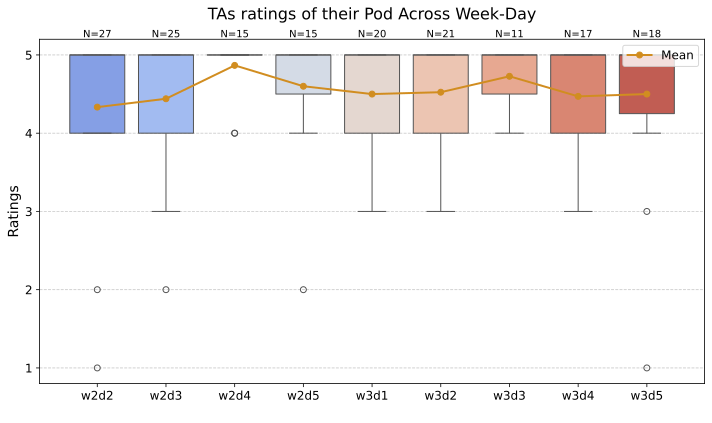

In [27]:
mean_values = combined_df.groupby('WeekDay')['2'].mean()

# Replace 0 with NaN
mean_values = mean_values.replace(0, np.nan).dropna()

# Count unique uids per weekday
uids_answered_per_weekday = combined_df.groupby('WeekDay')['uid'].nunique()

# Drop days where mean_values is NaN
uids_answered_per_weekday = uids_answered_per_weekday[mean_values.index]

# Filter the dataset to remove missing WeekDays
filtered_df = combined_df[combined_df['WeekDay'].isin(mean_values.index)]

colors = get_colors("NMA")

# Plot the boxplot
plt.figure(figsize=(10, 6))

ax = sns.boxplot(data=filtered_df, x='WeekDay', y='2', palette="coolwarm")
xticks_positions = [tick.get_position()[0] for tick in ax.get_xticklabels()]
xticks_labels = [tick.get_text() for tick in ax.get_xticklabels()]

# Add a line for the mean
plt.plot(mean_values.index, mean_values.values, color=colors[0], marker='o', linestyle='-', linewidth=2, label="Mean")

# Annotate
for label, x_position in zip(xticks_labels, xticks_positions):
    if label in uids_answered_per_weekday.index:  # Only annotate valid days
        plt.text(x_position, 5.2, f'N={uids_answered_per_weekday[label]}',
                 ha='center', va='bottom', fontsize=10, color='black')

plt.title("TAs ratings of their Pod Across Week-Day", fontsize=16, pad=20)
plt.xlabel(" ")
plt.ylabel("Ratings", fontsize=14)
plt.yticks([1, 2, 3, 4, 5], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc = 'upper right', fontsize=12)

plt.tight_layout()
plt.savefig('Podrating.png', dpi=400)
plt.show()

#files.download('Poddynamics.png')

**Obersvations**
Over 90% of TAs reported that they were either satisfied or very satisfied with their pod students.
The trend goes slightly up iby the end of the course.


# Q1

This question is conditional to the previous one (2). Only TAs that answered 1 or 2 could answer this question.

In [28]:
combined_df.groupby('uid')['Q1'].value_counts()

,,count
uid,Q1,
9368a6d4-6bd8-4143-ae58-c87887d07811,B,1
ec8eb03c-3e65-40d1-925a-e06171e1e03c,"A,C",1
fcb08161-b451-412e-a49a-edb5c890e7ce,C,1


In [29]:
combined_df.groupby(['WeekDay'])['Q1'].value_counts()

<ipython-input-29-3306cc082464>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_df.groupby(['WeekDay'])['Q1'].value_counts()


WeekDay  Q1 
w2d1     A,C    0
         B      0
         C      0
w2d2     A,C    0
         B      0
         C      0
w2d3     B      1
         A,C    0
         C      0
w2d4     A,C    0
         B      0
         C      0
w2d5     C      1
         A,C    0
         B      0
w3d1     A,C    0
         B      0
         C      0
w3d2     A,C    0
         B      0
         C      0
w3d3     A,C    0
         B      0
         C      0
w3d4     A,C    0
         B      0
         C      0
w3d5     A,C    1
         B      0
         C      0
Name: count, dtype: int64

**Only 3 mentors got to this question in 3 different weeks: w2d3, w2d5, w3d5**

Difficulties specified are:
A. Technical issues with platforms (e.g., Zoom, BBB) <br>
B. Communication challenges with students <br>
C. Lack of clarity in the task instructions

# Q1 Pilot


Using a Likert scale from `1 = Not effective at all` to 5 - `Extremely effective`, TAs rated how effective they felt in clarifying students' doubts.


In [ ]:
# Check in which day these questions are present.

missing_Q1P = combined_df.groupby('WeekDay')['Q1_Pilot'].value_counts(normalize=True) *100
print(missing_Q1P)

WeekDay  Q1_Pilot
w2d1     3.00        0.00
         4.00        0.00
         5.00        0.00
w2d2     4.00       59.26
         5.00       25.93
         3.00       14.81
w2d3     4.00       52.00
         5.00       36.00
         3.00       12.00
w2d4     5.00       73.33
         4.00       26.67
         3.00        0.00
w2d5     5.00       73.33
         3.00       13.33
         4.00       13.33
w3d1     5.00       45.00
         4.00       30.00
         3.00       25.00
w3d2     4.00       52.38
         5.00       38.10
         3.00        9.52
w3d3     5.00       54.55
         4.00       27.27
         3.00       18.18
w3d4     4.00       58.82
         5.00       29.41
         3.00       11.76
w3d5     5.00       66.67
         3.00       22.22
         4.00       11.11
Name: proportion, dtype: float64


<ipython-input-30-448f7574b705>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_Q1P = combined_df.groupby('WeekDay')['Q1_Pilot'].value_counts(normalize=True) *100


In [ ]:
Perc_Q1P = combined_df.groupby('WeekDay')['Q1_Pilot'].value_counts(normalize=True) * 100
print(Perc_Q1P)

WeekDay  Q1_Pilot
w2d1     3.00        0.00
         4.00        0.00
         5.00        0.00
w2d2     4.00       59.26
         5.00       25.93
         3.00       14.81
w2d3     4.00       52.00
         5.00       36.00
         3.00       12.00
w2d4     5.00       73.33
         4.00       26.67
         3.00        0.00
w2d5     5.00       73.33
         3.00       13.33
         4.00       13.33
w3d1     5.00       45.00
         4.00       30.00
         3.00       25.00
w3d2     4.00       52.38
         5.00       38.10
         3.00        9.52
w3d3     5.00       54.55
         4.00       27.27
         3.00       18.18
w3d4     4.00       58.82
         5.00       29.41
         3.00       11.76
w3d5     5.00       66.67
         3.00       22.22
         4.00       11.11
Name: proportion, dtype: float64


<ipython-input-31-d1adb8540c49>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Perc_Q1P = combined_df.groupby('WeekDay')['Q1_Pilot'].value_counts(normalize=True) * 100


In [ ]:
Global_perc_Q1P = combined_df['Q1_Pilot'].value_counts(normalize=True) * 100
print(Global_perc_Q1P)

Q1_Pilot
5.00   46.15
4.00   39.64
3.00   14.20
Name: proportion, dtype: float64


<ipython-input-33-bd62b9a22c44>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = combined_df.groupby('WeekDay')['Q1_Pilot'].mean()
<ipython-input-33-bd62b9a22c44>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uids_answered_per_weekday = combined_df.groupby('WeekDay')['uid'].nunique()
<ipython-input-33-bd62b9a22c44>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=filtered_df, x='WeekDay', y='Q1_Pilot', palette="coolwarm")


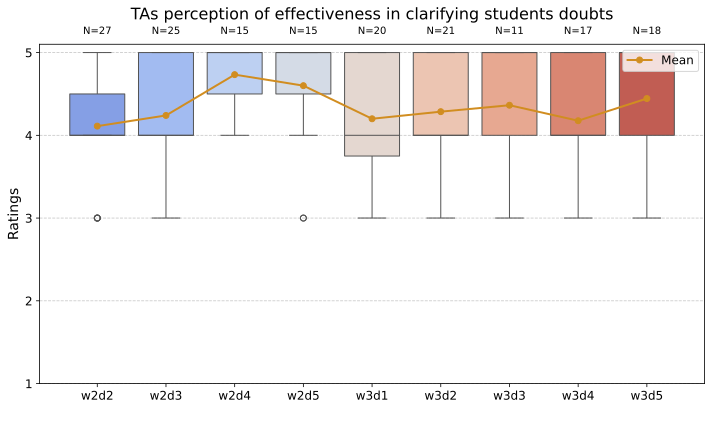

In [ ]:
mean_values = combined_df.groupby('WeekDay')['Q1_Pilot'].mean()

# Replace 0 with NaN
mean_values = mean_values.replace(0, np.nan).dropna()

# Count unique uids per weekday
uids_answered_per_weekday = combined_df.groupby('WeekDay')['uid'].nunique()

# Drop days where mean_values is NaN
uids_answered_per_weekday = uids_answered_per_weekday[mean_values.index]

# Filter the dataset to remove missing WeekDays
filtered_df = combined_df[combined_df['WeekDay'].isin(mean_values.index)]

colors = get_colors("NMA")

# Plot the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=filtered_df, x='WeekDay', y='Q1_Pilot', palette="coolwarm")

xticks_positions = [tick.get_position()[0] for tick in ax.get_xticklabels()]
xticks_labels = [tick.get_text() for tick in ax.get_xticklabels()]

# Add a line for the mean
plt.plot(mean_values.index, mean_values.values, color=colors[0], marker='o', linestyle='-', linewidth=2, label="Mean")

# Annotate
for label, x_position in zip(xticks_labels, xticks_positions):
    if label in uids_answered_per_weekday.index:  # Only annotate valid days
        plt.text(x_position, 5.2, f'N={uids_answered_per_weekday[label]}',
                 ha='center', va='bottom', fontsize=10, color='black')

plt.title("TAs perception of effectiveness in clarifying students doubts", fontsize=16, pad=25)
plt.xlabel(" ")
plt.ylabel("Ratings", fontsize=14)
plt.yticks([1, 2, 3, 4, 5], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc = 'upper right', fontsize=12)

plt.tight_layout()
plt.savefig('TAs_doubts.png', dpi=400)
plt.show()

#files.download('Poddynamics.png')

Over 85% of TAs reported they effectivelly helped students clarifying doubts.

# Q2_Pilot

This question was not mandatory and is an open text field.<br>
`Did you encounter any challenges in facilitating today's session? If yes, please briefly describe`

In [ ]:
combined_df.groupby('WeekDay')['Q2_Pilot'].unique()

<ipython-input-34-7123256f417a>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_df.groupby('WeekDay')['Q2_Pilot'].unique()


,Q2_Pilot
WeekDay,
w2d1,[nan]
w2d2,"[nan, The questions about content are the most..."
w2d3,"[nan, There is no written daily guide for proj..."
w2d4,"[nan, Students were not super enthusiastic abo..."
w2d5,"[nan, No, the students were collaborative with..."
w3d1,"[nan, The session was mostly interactive widge..."
w3d2,"[nan, we couldn't complete yesterday's last tu..."
w3d3,"[nan, Today I had the opportunity to get every..."
w3d4,[Interactive demo 2\nThe purpose of this demo ...


In [ ]:
grouped = combined_df.groupby('WeekDay')['Q2_Pilot'].unique()

for weekday, answers in grouped.items():
    print("\033[1m" + f"Weekday: {weekday}" + "\033[0m")

    for answer in answers:
        print(answer)
    print("-" * 40)

Weekday: w2d1
nan
----------------------------------------
Weekday: w2d2
nan
The questions about content are the most dificult to respond I think, and the content channel on discord doesn't help, I asked something and no one answer
4 tutorials are too much to be covered in 1 day. As the instructor said before, students face challenges after tutorial 2 in order to understand the differences between continuous VS discrete timing formulation and they need more time and content in order to understand well.
Some students where lacking the necessary linear algebra skills to understand the tutorials
No, I did not face any challenges. Members from my pod are quite experienced and seniors and are very much self-sufficient in learning about the different concepts and discussing with the pod in a very fruitful manner in case of any doubts.
Like last year,  we need more time to complete all tutorial content. Today, I could not finish the last section of the final tutorial.

didn't have time to fin

<ipython-input-35-f791f32ea66a>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = combined_df.groupby('WeekDay')['Q2_Pilot'].unique()


# Q9

`Approximately how many hours did you spend on preparatory work for today's session?`

A - Less than 1 hour<br>
B - 1-2 hours <br>
C - 2-3 hours<br>
D - More than 3 hours<br>


In [31]:
mapping_dict = {
    'A': 'Less than 1 hour',
    'B': '1-2 hours',
    'C': '2-3 hours',
    'D': 'More than 3 hours'
}

# Using .map()
combined_df['Q9'] = combined_df['Q9'].map(mapping_dict)

In [32]:
Perc_Q9 = combined_df.groupby('WeekDay')['Q9'].value_counts(normalize=True) * 100
print(Perc_Q9)

WeekDay  Q9               
w2d1     1-2 hours            0.00
         2-3 hours            0.00
         Less than 1 hour     0.00
         More than 3 hours    0.00
w2d2     2-3 hours           46.15
         1-2 hours           30.77
         Less than 1 hour    11.54
         More than 3 hours   11.54
w2d3     1-2 hours           40.00
         2-3 hours           32.00
         More than 3 hours   16.00
         Less than 1 hour    12.00
w2d4     1-2 hours           33.33
         2-3 hours           33.33
         Less than 1 hour    20.00
         More than 3 hours   13.33
w2d5     1-2 hours           60.00
         More than 3 hours   20.00
         Less than 1 hour    13.33
         2-3 hours            6.67
w3d1     1-2 hours           35.00
         2-3 hours           25.00
         Less than 1 hour    20.00
         More than 3 hours   20.00
w3d2     1-2 hours           30.00
         2-3 hours           30.00
         More than 3 hours   25.00
         Less than 1 hour   

<ipython-input-32-78eaa079f382>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Perc_Q9 = combined_df.groupby('WeekDay')['Q9'].value_counts(normalize=True) * 100


In [33]:
#print(combined_df[['WeekDay', 'TA_type', 'Q9']].head())
Perc_Q9_TA = combined_df.groupby(['WeekDay','TA_type'])['Q9'].value_counts(normalize=True) * 100
print(Perc_Q9_TA)

WeekDay  TA_type     Q9               
w2d1     Lead TA     1-2 hours            0.00
                     2-3 hours            0.00
                     Less than 1 hour     0.00
                     More than 3 hours    0.00
         Project TA  1-2 hours            0.00
                                          ... 
w3d5     Project TA  More than 3 hours    0.00
         Regular TA  1-2 hours           62.50
                     2-3 hours           25.00
                     Less than 1 hour     6.25
                     More than 3 hours    6.25
Name: proportion, Length: 120, dtype: float64


<ipython-input-33-53a7c831697f>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Perc_Q9_TA = combined_df.groupby(['WeekDay','TA_type'])['Q9'].value_counts(normalize=True) * 100


In [34]:
Perc_Q9 = combined_df.groupby('WeekDay')['Q9'].value_counts(normalize=True) * 100
print(Perc_Q9)

WeekDay  Q9               
w2d1     1-2 hours            0.00
         2-3 hours            0.00
         Less than 1 hour     0.00
         More than 3 hours    0.00
w2d2     2-3 hours           46.15
         1-2 hours           30.77
         Less than 1 hour    11.54
         More than 3 hours   11.54
w2d3     1-2 hours           40.00
         2-3 hours           32.00
         More than 3 hours   16.00
         Less than 1 hour    12.00
w2d4     1-2 hours           33.33
         2-3 hours           33.33
         Less than 1 hour    20.00
         More than 3 hours   13.33
w2d5     1-2 hours           60.00
         More than 3 hours   20.00
         Less than 1 hour    13.33
         2-3 hours            6.67
w3d1     1-2 hours           35.00
         2-3 hours           25.00
         Less than 1 hour    20.00
         More than 3 hours   20.00
w3d2     1-2 hours           30.00
         2-3 hours           30.00
         More than 3 hours   25.00
         Less than 1 hour   

<ipython-input-34-78eaa079f382>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Perc_Q9 = combined_df.groupby('WeekDay')['Q9'].value_counts(normalize=True) * 100


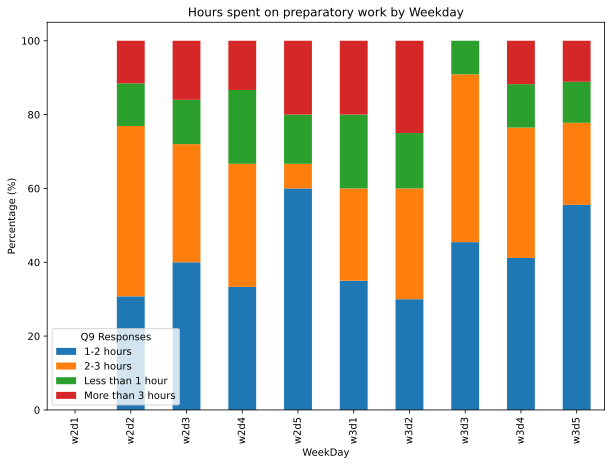

In [35]:
#Convert the Series to a DataFrame and reset the index
perc_q9_df = Perc_Q9.reset_index(name='Percentage')
# Pivot the DataFrame: rows are WeekDay, columns are Q9 answers, values are Percentage
perc_q9_pivot = perc_q9_df.pivot(index='WeekDay', columns='Q9', values='Percentage')

perc_q9_pivot.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.ylabel('Percentage (%)')
plt.title('Hours spent on preparatory work by Weekday')
plt.legend(title='Q9 Responses')
plt.show()

**Is the preparation time different based on the career status and type of TAs?**

Infomration related to career status are in the TAs_app dataset. Let's merge the datasets.

In [36]:
TAs_apps_path   ="/content/drive/MyDrive/Academies_DataAnalysis/General/TAs_ReceivedApp_from2021.csv"
TAs_app         = pd.read_csv(TAs_apps_path)

In [37]:
TAs_app = TAs_app[(TAs_app['course_id'] == 12) & (TAs_app['status'] == 'matched')]

In [38]:
print('Shape of combined_df before the merge is: ', combined_df.shape)
merged_df = combined_df.merge(TAs_app, left_on='uid', right_on='unique_id', how='left')
merged_df = merged_df.drop(columns='unique_id')

print('Shape of merge_df is: ', merged_df.shape)

Shape of combined_df before the merge is:  (198, 16)
Shape of merge_df is:  (198, 25)


In [39]:
# Calculate the percentages of Q9 responses by career_status and WeekDay
perc_q9 = merged_df.groupby(['career_status', 'WeekDay', 'TA_type'])['Q9'] \
                     .value_counts(normalize=True) * 100

perc_q9_df = perc_q9.reset_index(name='Percentage')

<ipython-input-39-c8ae684152fa>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perc_q9 = merged_df.groupby(['career_status', 'WeekDay', 'TA_type'])['Q9'] \


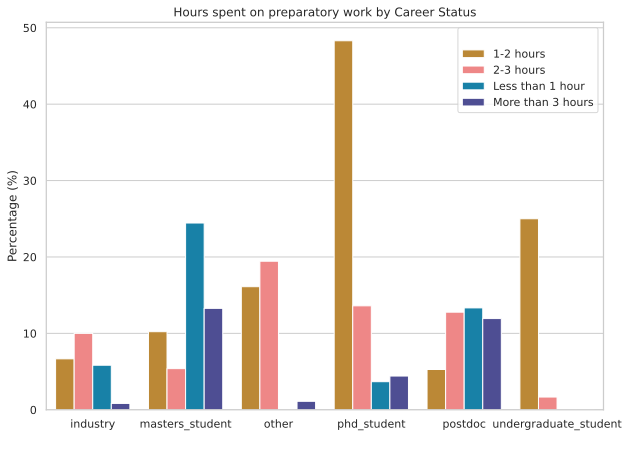

In [40]:
career_statuses = perc_q9_df['career_status'].unique()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))
sns.barplot(data=perc_q9_df, x='career_status', y='Percentage', hue='Q9',
            errorbar=None, palette=colors)

plt.xlabel(' ')
plt.ylabel('Percentage (%)')
plt.title('Hours spent on preparatory work by Career Status')
plt.legend(title=' ')
plt.show()

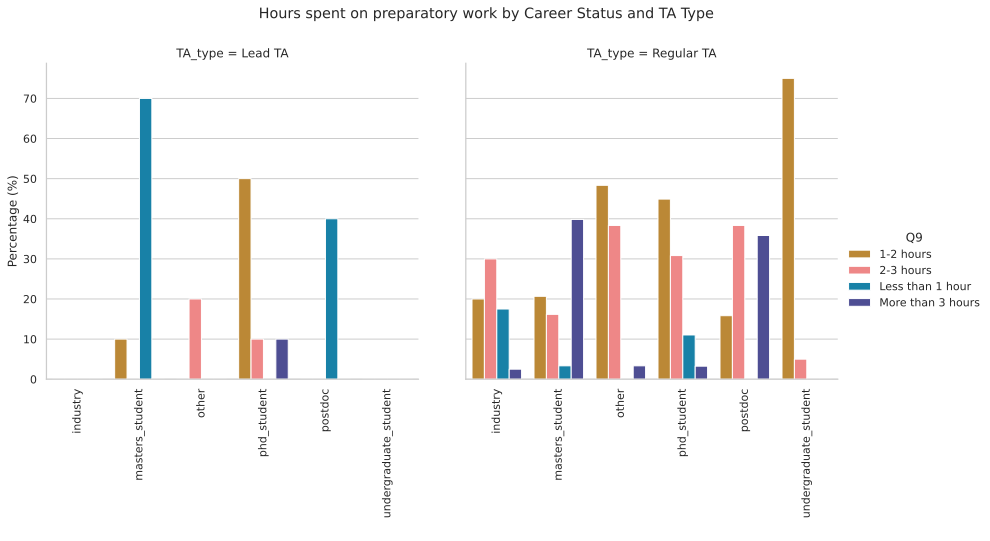

In [41]:
# Filter out rows with TA_type equal to "Project TA"
filtered_df = perc_q9_df[perc_q9_df['TA_type'] != 'Project TA']

# Faceted plot
sns.set(style="whitegrid")
g = sns.catplot(
    data=filtered_df,
    x='career_status',
    y='Percentage',
    hue='Q9',
    col='TA_type',
    kind='bar',
    errorbar=None,
    palette=colors, height=6, aspect=1)

g.set_xticklabels(rotation=90)
g.set_axis_labels(" ", "Percentage (%)")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Hours spent on preparatory work by Career Status and TA Type")
plt.show()


In [42]:
table = perc_q9_df.pivot_table(
    index=['career_status', 'TA_type'],
    columns='Q9',
    values='Percentage',
    fill_value=0)

# Reset the index
table_reset = table.reset_index()

q9_columns = [col for col in table_reset.columns if col not in ['career_status', 'TA_type']]

# Format the Q9 columns in the DataFrame
for col in q9_columns:
    table_reset[col] = table_reset[col].apply(lambda x: f"{x:.2f}%")

print(tabulate(table_reset, headers='keys', tablefmt='psql', showindex=False))

+-----------------------+------------+-------------+-------------+--------------------+---------------------+
| career_status         | TA_type    | 1-2 hours   | 2-3 hours   | Less than 1 hour   | More than 3 hours   |
|-----------------------+------------+-------------+-------------+--------------------+---------------------|
| industry              | Lead TA    | 0.00%       | 0.00%       | 0.00%              | 0.00%               |
| industry              | Project TA | 0.00%       | 0.00%       | 0.00%              | 0.00%               |
| industry              | Regular TA | 20.00%      | 30.00%      | 17.50%             | 2.50%               |
| masters_student       | Lead TA    | 10.00%      | 0.00%       | 70.00%             | 0.00%               |
| masters_student       | Project TA | 0.00%       | 0.00%       | 0.00%              | 0.00%               |
| masters_student       | Regular TA | 20.67%      | 16.17%      | 3.33%              | 39.83%              |
| other   

# Q13

In what ways do you think we can better support you in your role as a TA (other than responding to questions asked via emails and discord support tickets)? Please provide specific suggestions

In [ ]:
count_Q13 = combined_df.groupby('WeekDay')['Q13'].count()
print(count_Q13)

WeekDay
w2d1    0
w2d2    9
w2d3    7
w2d4    1
w2d5    2
w3d1    3
w3d2    5
w3d3    2
w3d4    2
w3d5    3
Name: Q13, dtype: int64


<ipython-input-48-3465028f6291>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_Q13 = combined_df.groupby('WeekDay')['Q13'].count()


In [ ]:
grouped1 = combined_df.groupby('WeekDay')['Q13'].unique()

for weekday, answers in grouped1.items():
    print("\033[1m" + f"Weekday: {weekday}" + "\033[0m")

    for answer in answers:
        print(answer)
    print("-" * 40)

Weekday: w2d1
nan
----------------------------------------
Weekday: w2d2
nan
I was thinking that maybe having optative reunions with the people that design the tutorial, 1 for each week topic I think, so we can ask things that we dont understand
maybe the number of tutorials should be less in some days like today and the estimated time of them should be more!
also I think you should provide extra bonus contents (or introduce bonus links) for each day for students/TAs who are less-experienced can understand better by studying them in their own time.
In my opinion, having a lead TA in the same country would be beneficial, as it would facilitate easier problem-solving.

I think there have been several questions I and other TAs have asked in the content help channels previously that have gone unanswered, which I don't know if it is because of the later time zone I'm in - it would be helpful to have more regular monitoring and responding in those channels. I did get answers today, which is 

<ipython-input-49-50f807e0d924>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped1 = combined_df.groupby('WeekDay')['Q13'].unique()


# Q14

Do you have any additional comments or feedback you would like to share regarding your experience as a TA?

In [ ]:
grouped2 = combined_df.groupby('WeekDay')['Q14'].unique()

for weekday, answers in grouped2.items():
    print("\033[1m" + f"Weekday: {weekday}" + "\033[0m")

    for answer in answers:
        print(answer)
    print("-" * 40)

Weekday: w2d1
nan
I think the people that stayed are really compatible with their background, I like the way that they work toguether and treat each other. 
they are much more active in project times rather  than tutorial times. I am trying to fix it
Two of the pod members dropped the course. How should I proceed with the official procedure to do that?
My students are motivated and eager to learn. I enjoy being with them. However, two students have not turned the cameras on due to internet problems.
not so far
Everything is good so far.
My pod already merged with another because of a TA dropping out, this is why the numbers are so high. The students are all great, and I really appreciate their high level of participation and communication!
One of the groups is more actively involved in doing their project on IBL dataset. The other working on the Bayes heuristics dataset seem to be less motivated and less interested in their dataset.  
Some students really refuse to interact but accept 

<ipython-input-50-29bcdf66a8bb>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped2 = combined_df.groupby('WeekDay')['Q14'].unique()


#  Q15 - attending     

This question is present in w2d1 only. It's a free text.

`How many students are actively attending your pod?`

In [ ]:
combined_df['Q15 - attending'].unique()


array([15., 10.,  8.,  9.,  6., 17., 11., 12., 14., 19.,  7., nan])

In [ ]:
average_attendance = combined_df['Q15 - attending'].mean()
average_attendance

11.448275862068966

On average 11 students per pod are attending the course after 1 week.

# Q18 - never showed

This question is present in w2d1 only. It's a free text.

`How many students that are listed on the Portal as in your pod never showed up`

In [ ]:
combined_df['Q18 - never showed'].unique()


array([ 1.,  0.,  2.,  4.,  8.,  3.,  6.,  9.,  5.,  7., 20., nan])

The `20` must have been an error given that the `Hopeful Rondeletia` pod has 20 students (checked in the portal).

In [ ]:
# Filter out row containing 20
filtered_df = combined_df[combined_df['Q18 - never showed'] != 20]

#
average_never_shown = filtered_df['Q18 - never showed'].mean()
average_never_shown

4.038461538461538

On average 4 students per pod didnt show up after 1 week.

# Q16 - projects    

This question is present in w2d1 only. It's a free text.

`How many students are actively taking part in the Projects portion?`

In [ ]:
combined_df['Q16 - projects'].unique()

array([12., 10.,  8.,  7.,  5., 15., 11., 14., 13., 18.,  9., nan])

In [ ]:
average_project = combined_df['Q16 - projects'].mean()
average_project

10.586206896551724

On average 10 students per pod are attending the project part of the course after 1 week.